In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import ADASYN

In [89]:
from tensorflow.keras.layers import Input,InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D,LeakyReLU
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Sequential

In [27]:
data_dir = "./Alzheimers-ADNI/train"
data_dir1 = "./Alzheimers-ADNI/test"
classes = ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']
print(os.listdir(data_dir))

['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']


In [6]:
images = []
labels = []
for subfolder in tqdm(os.listdir('./Alzheimers-ADNI')):
    subfolder_path = os.path.join('./Alzheimers-ADNI', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})

def remove_jpeg(label):
    return label.replace(' JPEG', '')
df['label'] = df['label'].apply(remove_jpeg)
df

100%|██████████| 2/2 [00:00<00:00, 61.03it/s]


,image,label
0,./Alzheimers-ADNI\test\Final AD JPEG\ADNI_002_...,Final AD
1,./Alzheimers-ADNI\test\Final AD JPEG\ADNI_006_...,Final AD
2,./Alzheimers-ADNI\test\Final AD JPEG\ADNI_012_...,Final AD
3,./Alzheimers-ADNI\test\Final AD JPEG\ADNI_013_...,Final AD
4,./Alzheimers-ADNI\test\Final AD JPEG\ADNI_024_...,Final AD
...,...,...
1291,./Alzheimers-ADNI\train\Final MCI JPEG\ADNI_30...,Final MCI
1292,./Alzheimers-ADNI\train\Final MCI JPEG\ADNI_30...,Final MCI
1293,./Alzheimers-ADNI\train\Final MCI JPEG\ADNI_30...,Final MCI
1294,./Alzheimers-ADNI\train\Final MCI JPEG\ADNI_94...,Final MCI


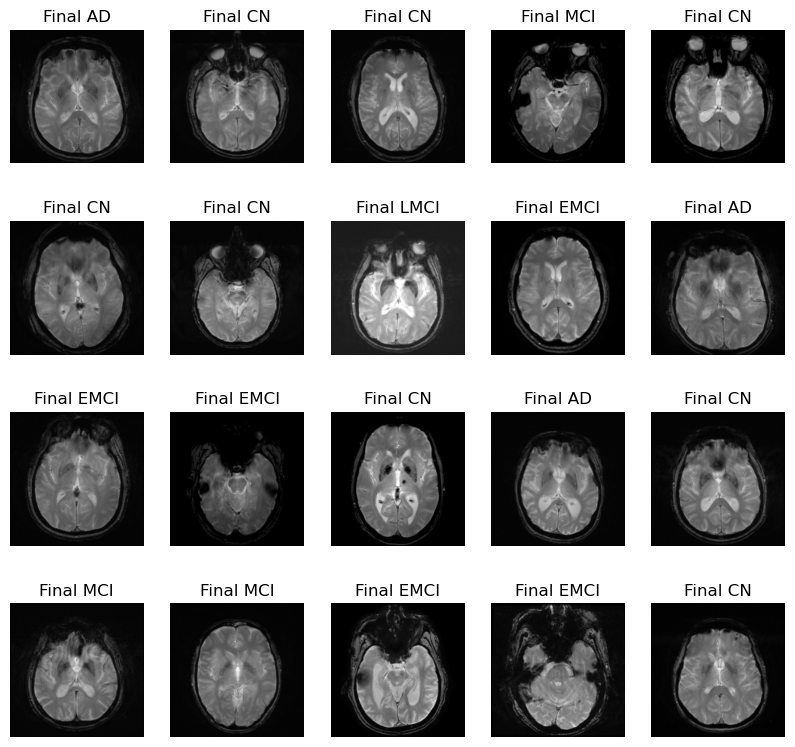

In [7]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=12)

In [41]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    horizontal_flip=True,
    fill_mode='nearest'
)
Size=(256,256)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',  
    y_col='label',  
    target_size=Size,
    batch_size=1500,
    class_mode='categorical'  
)


Found 1296 validated image filenames belonging to 5 classes.


In [64]:
train_data, train_labels = train_generator.next()

In [65]:
train_data.shape

(1296, 256, 256, 3)

In [15]:
for alzheimers_class in classes:
    container = []
    temp_dir = data_dir + "/" + alzheimers_class
    for file in os.listdir(temp_dir):
        container.append(file)
    print(alzheimers_class, ": ", len(container))

Final AD JPEG :  145
Final CN JPEG :  493
Final EMCI JPEG :  204
Final LMCI JPEG :  61
Final MCI JPEG :  198


In [29]:
for alzheimers_class in classes:
    container = []
    temp_dir = data_dir1 + "/" + alzheimers_class
    for file in os.listdir(temp_dir):
        container.append(file)
    print(alzheimers_class, ": ", len(container))

Final AD JPEG :  26
Final CN JPEG :  87
Final EMCI JPEG :  36
Final LMCI JPEG :  11
Final MCI JPEG :  35


In [66]:
train_data_flat = train_data.reshape(-1, 256 * 256 * 3)

adasyn = ADASYN(sampling_strategy='auto', n_neighbors=7, random_state=42)

train_data, train_labels = adasyn.fit_resample(train_data_flat, train_labels)
train_data = train_data.reshape(-1, 256, 256, 3)

print("Shape of train_data_resampled:", train_data.shape)
print("Shape of train_labels_resampled:", train_labels.shape)

Shape of train_data_resampled: (2953, 256, 256, 3)
Shape of train_labels_resampled: (2953, 5)


In [69]:
from collections import Counter
class_counts = Counter(np.argmax(train_labels, axis=1))
for class_idx, count in class_counts.items():
    print(f"Class {class_idx}: {count} samples")

Class 4: 611 samples
Class 1: 580 samples
Class 0: 562 samples
Class 2: 598 samples
Class 3: 602 samples


In [119]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.2, random_state=101,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=101,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (2362, 256, 256, 3)
X_test shape is  (296, 256, 256, 3)
X_val shape is  (295, 256, 256, 3)
y_train shape is  (2362, 5)
y_test shape is  (296, 5)
y_val shape is  (295, 5)


In [130]:
tf.keras.backend.clear_session()

In [131]:
def create_model(alpha=0.2):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=3, padding='same', input_shape=(256, 256, 3)))
    model.add(LeakyReLU(alpha=alpha))
    model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=32, kernel_size=5, padding='same'))
    model.add(LeakyReLU(alpha=alpha))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128, kernel_size=5, padding='same'))
    model.add(LeakyReLU(alpha=alpha))
    model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=7, padding='same'))
    model.add(LeakyReLU(alpha=alpha))
    model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=alpha))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=alpha))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    return model

model1 = create_model()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 8)       0         
                                                                 
 average_pooling2d (Average  (None, 128, 128, 8)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      6432      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                         

In [100]:
def create_model(alpha=0.1):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', input_shape=(256, 256, 3)))
    model.add(LeakyReLU(alpha=alpha))
    model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=5, padding='same'))
    model.add(LeakyReLU(alpha=alpha))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128, kernel_size=7, padding='same'))
    model.add(LeakyReLU(alpha=alpha))
    model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=alpha))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=alpha))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 average_pooling2d (Average  (None, 128, 128, 32)      0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                         

In [101]:
OPT = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]
model.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)

earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1)
checkpoint = ModelCheckpoint("cnn1.keras", save_best_only=True)
callback_list = [earlystopping, checkpoint]

hist = model.fit(X_train,y_train, epochs=60, validation_data=(X_val,y_val), callbacks=callback_list)

Epoch 1/60
74/74 [==============================] - 308s 4s/step - loss: 1.7110 - acc: 0.3222 - auc: 0.6263 - val_loss: 3.4724 - val_acc: 0.1898 - val_auc: 0.5085
Epoch 2/60
74/74 [==============================] - 297s 4s/step - loss: 1.3272 - acc: 0.4793 - auc: 0.7702 - val_loss: 3.7933 - val_acc: 0.1898 - val_auc: 0.5191
Epoch 3/60
74/74 [==============================] - 294s 4s/step - loss: 0.9856 - acc: 0.6245 - auc: 0.8777 - val_loss: 3.6749 - val_acc: 0.1898 - val_auc: 0.5344
Epoch 4/60
74/74 [==============================] - 295s 4s/step - loss: 0.7166 - acc: 0.7371 - auc: 0.9373 - val_loss: 3.2642 - val_acc: 0.1898 - val_auc: 0.5474
Epoch 5/60
74/74 [==============================] - 296s 4s/step - loss: 0.5263 - acc: 0.8167 - auc: 0.9676 - val_loss: 2.2427 - val_acc: 0.2136 - val_auc: 0.6522
Epoch 6/60
74/74 [==============================] - 295s 4s/step - loss: 0.3960 - acc: 0.8734 - auc: 0.9813 - val_loss: 1.0706 - val_acc: 0.5932 - val_auc: 0.8549
Epoch 7/60
74/74 [====

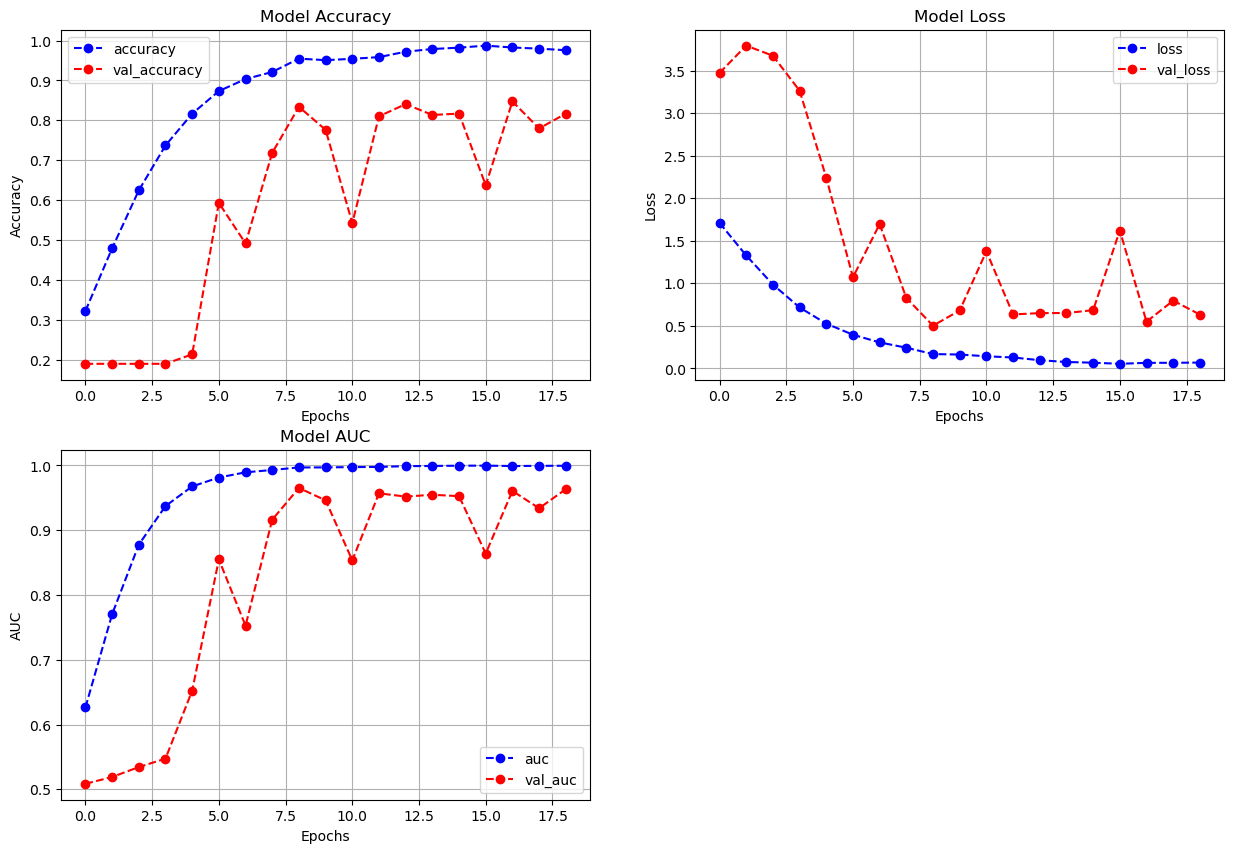

In [125]:
def accuracy_loss_plot (hist):
    fig = plt.figure(figsize=(15,10))
    
    plt.subplot(221)
    plt.plot(hist.history['acc'], 'bo--', label="accuracy")
    plt.plot(hist.history['val_acc'], 'ro--', label="val_accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    
    plt.subplot(222)
    plt.plot(hist.history['loss'], "bo--", label="loss")
    plt.plot(hist.history['val_loss'], "ro--", label = "val_loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    
    plt.subplot(223)
    plt.plot(hist.history['auc'], "bo--", label="auc")
    plt.plot(hist.history['val_auc'], "ro--", label = "val_auc")
    plt.title("Model AUC")
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.grid()
    plt.legend()
    
    plt.show()

accuracy_loss_plot(hist)

In [117]:
test_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',  
    y_col='label',  
    target_size=Size,
    batch_size=120,
    class_mode='categorical'  
)
X_test, y_test = test_generator.next()

Found 1296 validated image filenames belonging to 5 classes.


In [134]:
score, acc,auc= model1.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Auc =', auc)

10/10 [==============================] - 10s 938ms/step - loss: 0.5677 - acc: 0.8311 - auc: 0.9678
Test Loss = 0.5676575303077698
Test Accuracy = 0.8310810923576355
Test Auc = 0.967797040939331


In [121]:
y_pred = model.predict(X_test)
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in y_pred:
    labels = roundoff(labels)

10/10 [==============================] - 12s 1s/step


In [122]:
classes = ['AD','CN', 'EMCI', 'LMCI', 'MCI']
print(classification_report(y_test, y_pred, target_names=classes,zero_division=1))

              precision    recall  f1-score   support

          AD       0.88      0.93      0.90        56
          CN       0.68      0.45      0.54        58
        EMCI       0.79      0.80      0.79        60
        LMCI       1.00      1.00      1.00        61
         MCI       0.75      0.95      0.84        61

   micro avg       0.83      0.83      0.83       296
   macro avg       0.82      0.83      0.82       296
weighted avg       0.82      0.83      0.82       296
 samples avg       0.83      0.83      1.00       296



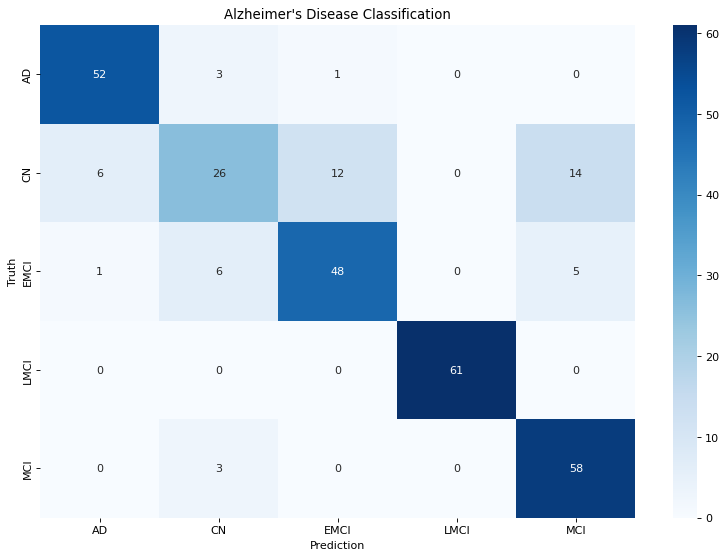

In [123]:
pred_ls = np.argmax(y_pred, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('Alzheimer\'s Disease Classification')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [133]:
OPT = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]
model1.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)

earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20, verbose = 1)
checkpoint = ModelCheckpoint("cnn2.keras", save_best_only=True)
callback_list = [earlystopping, checkpoint]

hist = model1.fit(X_train,y_train, epochs=50, validation_data=(X_val,y_val), callbacks=callback_list)

Epoch 1/50
74/74 [==============================] - 279s 4s/step - loss: 1.7712 - acc: 0.2727 - auc: 0.5995 - val_loss: 2.5736 - val_acc: 0.2102 - val_auc: 0.5149
Epoch 2/50
74/74 [==============================] - 270s 4s/step - loss: 1.5895 - acc: 0.3577 - auc: 0.6647 - val_loss: 2.4900 - val_acc: 0.1932 - val_auc: 0.5237
Epoch 3/50
74/74 [==============================] - 269s 4s/step - loss: 1.3622 - acc: 0.4526 - auc: 0.7546 - val_loss: 2.8960 - val_acc: 0.1864 - val_auc: 0.5361
Epoch 4/50
74/74 [==============================] - 268s 4s/step - loss: 1.2038 - acc: 0.5178 - auc: 0.8127 - val_loss: 2.6274 - val_acc: 0.1898 - val_auc: 0.5974
Epoch 5/50
74/74 [==============================] - 269s 4s/step - loss: 1.0439 - acc: 0.5957 - auc: 0.8609 - val_loss: 2.2355 - val_acc: 0.2407 - val_auc: 0.6058
Epoch 6/50
74/74 [==============================] - 270s 4s/step - loss: 0.9424 - acc: 0.6439 - auc: 0.8874 - val_loss: 1.1233 - val_acc: 0.5220 - val_auc: 0.8393
Epoch 7/50
74/74 [====